In [1]:
import pandas as pd
import numpy as np
from scipy.stats import zscore
from backtesting import Backtest, Strategy
from backtesting.lib import crossover
import talib as ta
import matplotlib.pyplot as plt

# Load data
data = pd.read_csv('../marketDataNasdaqFutures/1m.csv')
data['timestamp'] = pd.to_datetime(data['ts_event'])
data = data.set_index('timestamp')

# Removes the spread data
symbol_mask = ~data['symbol'].str.contains('-', na=False)
data = data[symbol_mask]

# Filter for quarterly contracts
quarterly_contracts = {"H": "March", "M": "June", "U": "September", "Z": "December"}
contracts = [f"NQ{month_code}{year}" for year in range(0,6) for month_code in quarterly_contracts.keys() ]
data = data[data['symbol'].isin(contracts)]

data = data[(data.index.day_of_week < 5) ]

# Collect timestamps for contract switchovers:
data_prices = data.pivot_table(index=data.index, columns='symbol', values=['volume'])
cols_order = pd.MultiIndex.from_product([['close', 'volume'], contracts])
data_prices = data_prices.reindex(columns=cols_order)
volume = data_prices['volume']

switchover_dates = []

for i in range(len(contracts) - 1):
    front = contracts[i]
    nxt   = contracts[i+1]

    # Boolean mask: next > 1.2 * front
    mask = volume[nxt] > volume[front] * 1.2

    # Require the condition to hold for 3 consecutive days
    mask_persist = mask.rolling(window=3, min_periods=3).sum() == 3

    # Get the last date of the first qualifying run
    end_date = mask_persist.idxmax() if mask_persist.any() else None

    # Adjust to the start of the window (subtract window-1 days)
    start_date = end_date - pd.Timedelta(days=3-1) if end_date is not None else None

    first_trigger = start_date

    switchover_dates.append((front, nxt, first_trigger))
print(switchover_dates[2:-1])
contract_periods = {'NQU0': (min(data.index),switchover_dates[2][2])}
contract_periods = {switchover_dates[i+2][0]: (switchover_dates[i+1][2],switchover_dates[i+2][2] if switchover_dates[i+2][2] else None) for i in range(len(switchover_dates)-2)}
contract_periods


/opt/miniconda3/envs/ta-reversals-env/lib/python3.11/site-packages/backtesting/_plotting.py:55: UserWarning: Jupyter Notebook detected. Setting Bokeh output to notebook. This may not work in Jupyter clients without JavaScript support, such as old IDEs. Reset with `backtesting.set_bokeh_output(notebook=False)`.
  warnings.warn('Jupyter Notebook detected. '


Loading BokehJS ...

[('NQU0', 'NQZ0', Timestamp('2020-09-09 18:58:00+0000', tz='UTC')), ('NQZ0', 'NQH1', Timestamp('2020-12-09 13:54:00+0000', tz='UTC')), ('NQH1', 'NQM1', Timestamp('2021-03-10 16:48:00+0000', tz='UTC')), ('NQM1', 'NQU1', Timestamp('2021-06-09 13:34:00+0000', tz='UTC')), ('NQU1', 'NQZ1', Timestamp('2021-09-07 22:52:00+0000', tz='UTC')), ('NQZ1', 'NQH2', Timestamp('2021-12-08 03:26:00+0000', tz='UTC')), ('NQH2', 'NQM2', Timestamp('2022-03-09 00:01:00+0000', tz='UTC')), ('NQM2', 'NQU2', Timestamp('2022-06-11 04:31:00+0000', tz='UTC')), ('NQU2', 'NQZ2', Timestamp('2022-09-10 08:19:00+0000', tz='UTC')), ('NQZ2', 'NQH3', Timestamp('2022-12-06 23:13:00+0000', tz='UTC')), ('NQH3', 'NQM3', Timestamp('2023-03-11 03:43:00+0000', tz='UTC')), ('NQM3', 'NQU3', Timestamp('2023-06-10 00:02:00+0000', tz='UTC')), ('NQU3', 'NQZ3', Timestamp('2023-09-09 00:20:00+0000', tz='UTC')), ('NQZ3', 'NQH4', Timestamp('2023-12-09 00:17:00+0000', tz='UTC')), ('NQH4', 'NQM4', Timestamp('2024-03-09 00:04:00+0000', tz='UT

{'NQU0': (None, Timestamp('2020-09-09 18:58:00+0000', tz='UTC')),
 'NQZ0': (Timestamp('2020-09-09 18:58:00+0000', tz='UTC'),
  Timestamp('2020-12-09 13:54:00+0000', tz='UTC')),
 'NQH1': (Timestamp('2020-12-09 13:54:00+0000', tz='UTC'),
  Timestamp('2021-03-10 16:48:00+0000', tz='UTC')),
 'NQM1': (Timestamp('2021-03-10 16:48:00+0000', tz='UTC'),
  Timestamp('2021-06-09 13:34:00+0000', tz='UTC')),
 'NQU1': (Timestamp('2021-06-09 13:34:00+0000', tz='UTC'),
  Timestamp('2021-09-07 22:52:00+0000', tz='UTC')),
 'NQZ1': (Timestamp('2021-09-07 22:52:00+0000', tz='UTC'),
  Timestamp('2021-12-08 03:26:00+0000', tz='UTC')),
 'NQH2': (Timestamp('2021-12-08 03:26:00+0000', tz='UTC'),
  Timestamp('2022-03-09 00:01:00+0000', tz='UTC')),
 'NQM2': (Timestamp('2022-03-09 00:01:00+0000', tz='UTC'),
  Timestamp('2022-06-11 04:31:00+0000', tz='UTC')),
 'NQU2': (Timestamp('2022-06-11 04:31:00+0000', tz='UTC'),
  Timestamp('2022-09-10 08:19:00+0000', tz='UTC')),
 'NQZ2': (Timestamp('2022-09-10 08:19:00+0000'

In [2]:
# data = data[(data.index.year == 2024 )]

# # Groups by contracts
# data_prices = data.pivot_table(index=data.index, columns='symbol', values=['close', 'volume'])

# # Fixed contract order
# contracts = data_prices['close'].columns.tolist()

# # Assign fixed colors per contract
# color_map = plt.cm.tab10.colors  # or another palette
# color_dict = {c: color_map[i % len(color_map)] for i, c in enumerate(contracts)}

# fig, ax1 = plt.subplots(figsize=(16, 8))

# # Plot Close on primary y-axis
# for c in contracts:
#     ax1.plot(
#         data_prices.index,
#         data_prices['close'][c],
#         label=f"{c} (Close)",
#         color=color_dict[c],
#         linewidth=1.5
#     )

# ax1.set_xlabel('Date')
# ax1.set_ylabel('Price')
# ax1.set_title('Price and Volume per Contract for 2024')

# # Second y-axis for Volume — scaled to half
# ax2 = ax1.twinx()
# for c in contracts:
#     ax2.fill_between(
#         data_prices.index,
#         data_prices['volume'][c],
#         color=color_dict[c],
#         alpha=0.3,
#         label=f"{c} (Volume)"
#     )

# ax2.set_ylabel('Volume')
# month_map = {
#     'F': 'January', 'G': 'February', 'H': 'March', 'J': 'April',
#     'K': 'May', 'M': 'June', 'N': 'July', 'Q': 'August',
#     'U': 'September', 'V': 'October', 'X': 'November', 'Z': 'December'
# }
# # Merge legends from both axes, keeping order
# handles1, labels1 = ax1.get_legend_handles_labels()
# handles2, labels2 = ax2.get_legend_handles_labels()

# for label in labels1:
#     if label[2] in month_map.keys():
#         labels1[labels1.index(label)] = f"{label[:4]} ({month_map[label[2]]} 202{label[3]})"

# ax1.legend(handles1, labels1, title="Contract", loc='upper left')

# plt.tight_layout()
# plt.show()


In [3]:

data_prices = data.pivot_table(index=data.index,
                               columns='symbol',
                               values=['open', 'high', 'low', 'close', 'volume'])

close = data_prices['close']
volume = data_prices['volume']

continuous_timeseries_open = []
continuous_timeseries_high = []
continuous_timeseries_low = []
continuous_timeseries_close = []
continuous_timeseries_volume = []
continuous_timeseries_symbol = []

for contract, (start, end) in contract_periods.items():
    # Slice one symbol out (level=1) and drop the symbol from the column index
    contract_data = (
        data_prices.loc[start:end, (slice(None), contract)]
        .droplevel(1, axis=1)
    )

    # Forward-fill in place
    contract_data.ffill(inplace=True)

    # Append
    continuous_timeseries_symbol.extend([contract] * len(contract_data))
    continuous_timeseries_open.append(contract_data['open'])
    continuous_timeseries_high.append(contract_data['high'])
    continuous_timeseries_low.append(contract_data['low'])
    continuous_timeseries_close.append(contract_data['close'])
    continuous_timeseries_volume.append(contract_data['volume'])

# Combine into continuous Series
continuous_open   = pd.concat(continuous_timeseries_open)
continuous_high   = pd.concat(continuous_timeseries_high)
continuous_low    = pd.concat(continuous_timeseries_low)
continuous_close  = pd.concat(continuous_timeseries_close)
continuous_volume = pd.concat(continuous_timeseries_volume)

continuous_df = pd.DataFrame({
    'open': continuous_open,
    'high': continuous_high,
    'low': continuous_low,
    'close': continuous_close,
    'volume': continuous_volume,
    'symbol': continuous_timeseries_symbol
})
len(continuous_df['symbol'].unique())

21

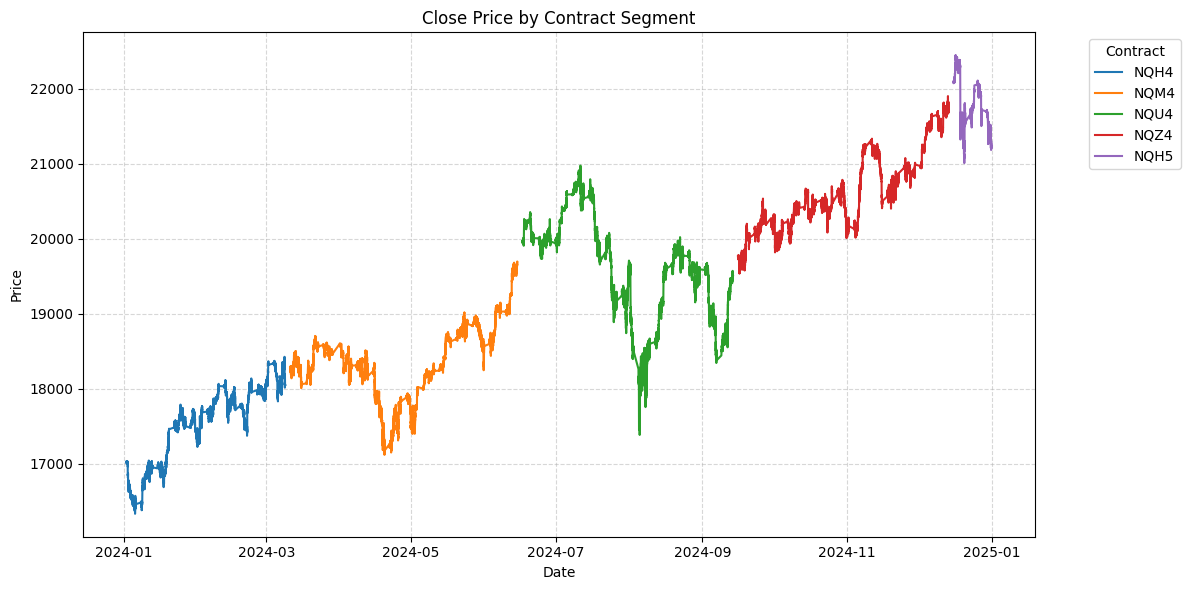

In [4]:
import matplotlib.pyplot as plt

def plot_segments(df, price_col='close', volume=True):
    """
    Plot a price column with different colours for each contract segment,
    with a volume overlay on a secondary y-axis.

    Parameters
    ----------
    df : pd.DataFrame
        Must contain a DatetimeIndex (or sortable index), `symbol` column, and chosen price_col.
    price_col : str
        The column to plot (e.g. 'close', 'open', etc.).
    """
    fig, ax = plt.subplots(figsize=(12, 6))
    
    # Plot price segments by contract (original logic)
    for symbol, segment in df.groupby('symbol', sort=False):
        ax.plot(segment.index, segment[price_col],
                label=str(symbol),
                linewidth=1.5)

    # Volume overlay (secondary y-axis)
    if volume:
        ax2 = ax.twinx()
        ax2.fill_between(df.index, df['volume'], 0, color='tab:orange', alpha=0.25, step='pre')
        ax2.set_ylabel('Volume')
        ax2.grid(False)
        ax2.set_zorder(0)
        ax.set_zorder(1)
        ax.patch.set_alpha(0.0)

    ax.set_title(f'{price_col.capitalize()} Price by Contract Segment')
    ax.set_xlabel('Date')
    ax.set_ylabel('Price')
    ax.grid(True, linestyle='--', alpha=0.5)
    ax.legend(title='Contract', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

# Example usage
plot_segments(continuous_df[continuous_df.index.year==2024], price_col='close', volume=False)

In [5]:
import pandas as pd
import numpy as np

def ratio_back_adjust_from_segments(open_list, high_list, low_list, close_list, volume_list,
                                    method='log-median', window=None, lookback_window=1000):
    """
    Build a ratio back-adjusted continuous series from lists of OHLCV segments
    (each segment = one contract's active period, in chronological order).

    Parameters
    ----------
    open_list, high_list, low_list, close_list, volume_list : list of pd.Series
        Each list element is a segment for one contract.
    method : {'median', 'log-median'}, optional
        How to compute the roll ratio.
    window : int or None
        If given, compute the ratio over this many *last* points of overlap;
        None means use all overlap.

    Returns
    -------
    continuous_df : pd.DataFrame
        Back-adjusted continuous OHLCV.
    ratios : list of (contract_idx, ratio)
        Ratios applied at each roll boundary (idx = index in list where roll *to* happens).
    """
    # Defensive length check
    n_segments = len(close_list)
    assert all(len(lst) == n_segments for lst in
               [open_list, high_list, low_list, close_list, volume_list]), \
        "All OHLCV lists must have the same length"

    adjusted_segments = []
    cum_factor = 1.0
    ratios = []

    # Go from most recent backwards
    for i in reversed(range(n_segments)):
        # Apply cumulative factor to O/H/L/C
        adj_open = open_list[i] * cum_factor
        adj_high = high_list[i] * cum_factor
        adj_low  = low_list[i] * cum_factor
        adj_close = close_list[i] * cum_factor
        adj_volume = volume_list[i]  # volume untouched

        adjusted_segments.append(pd.DataFrame({
            'open': adj_open,
            'high': adj_high,
            'low': adj_low,
            'close': adj_close,
            'volume': adj_volume
        }))

        # Compute ratio for next loop (previous contract)
        if i > 0:
            # Align the two segments at the join point
            prev_seg_close = close_list[i-1]
            curr_seg_close = close_list[i]

            overlap_idx = prev_seg_close.index.intersection(curr_seg_close.index)
            if window is not None and window < len(overlap_idx):
                overlap_idx = overlap_idx[-window:]

            prev_px = prev_seg_close.loc[overlap_idx].astype(float)
            curr_px = curr_seg_close.loc[overlap_idx].astype(float)

            # Drop bad/missing points
            valid = prev_px.notna() & curr_px.notna() & (prev_px > 0) & (curr_px > 0)
            prev_px = prev_px[valid]
            curr_px = curr_px[valid]

            if not prev_px.empty:
                if method == 'median':
                    ratio = np.median(curr_px.values / prev_px.values)
                elif method == 'log-median':
                    ratio = np.exp(np.median(np.log(curr_px.values) - np.log(prev_px.values)))
            else:
                # fallback: boundary ratio using up to 5 bars
                curr_px = curr_seg_close.iloc[:lookback_window].dropna()
                prev_px = prev_seg_close.iloc[-lookback_window:].dropna()
                n = min(len(curr_px), len(prev_px))

                if n < 1:
                    ratio = 1.0
                else:
                    curr_px = curr_px.iloc[:n]
                    prev_px = prev_px.iloc[-n:]

                    if method == 'median':
                        ratio = np.median(curr_px.values / prev_px.values)
                    elif method == 'log-median':
                        ratio = np.exp(np.median(np.log(curr_px.values) - np.log(prev_px.values)))

            ratios.append((i, ratio))
            cum_factor *= ratio

    # Concatenate back in chronological order
    continuous_df = pd.concat(reversed(adjusted_segments))
    continuous_df = continuous_df[~continuous_df.index.duplicated(keep='first')].sort_index()

    return continuous_df, list(reversed(ratios))


continuous_df_backadjusted, roll_ratios = ratio_back_adjust_from_segments(
    continuous_timeseries_open,
    continuous_timeseries_high,
    continuous_timeseries_low,
    continuous_timeseries_close,
    continuous_timeseries_volume,
    method='log-median',   # robust default
    window=50,               # e.g. last 5 bars before roll
    lookback_window=1000 #ratio over roughly 1 trading day (minute data)
)

continuous_df_backadjusted['symbol'] = continuous_timeseries_symbol[:-8]
print(roll_ratios)  # list of (segment_index, ratio)




[(1, np.float64(1.0115627501556523)), (2, np.float64(0.9773441670126326)), (3, np.float64(0.9997461086264469)), (4, np.float64(0.9992068499324022)), (5, np.float64(0.9985648221974159)), (6, np.float64(1.0002286445948412)), (7, np.float64(1.0078582702523322)), (8, np.float64(0.9503724271200483)), (9, np.float64(1.0180022053414066)), (10, np.float64(0.9917315071978294)), (11, np.float64(1.0131054252992346)), (12, np.float64(1.0182337385036615)), (13, np.float64(1.01731341122676)), (14, np.float64(1.0162484501886497)), (15, np.float64(0.9991866252723997)), (16, np.float64(1.017343655505161)), (17, np.float64(1.0143574457645506)), (18, np.float64(1.016489520420055)), (19, np.float64(1.0169425168728665)), (20, np.float64(1.0145457286809443))]


In [6]:
# Clean the continuous back-adjusted futures NQ data for outliers
from scipy.stats import median_abs_deviation
cols = ['open', 'high', 'low', 'close']
df = continuous_df_backadjusted[cols]
med = df.median()
mad = df.apply(median_abs_deviation)
robust_z = (df - med) / mad
mask = robust_z.abs() > 6  # ~3σ equivalent for MAD
continuous_df_backadjusted[cols] = df.mask(mask)
continuous_df_backadjusted.fillna(method='ffill', inplace=True)
continuous_df_backadjusted.isna().sum()
continuous_df_backadjusted.to_csv('NQ_continuous_backadjusted_1m_cleaned.csv')


continuous_df_backadjusted


/var/folders/mv/z1xz77z55w58nq2fljfj8dvh0000gn/T/ipykernel_59236/1360302050.py:10: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  continuous_df_backadjusted.fillna(method='ffill', inplace=True)


,open,high,low,close,volume,symbol
timestamp,,,,,,
2020-07-20 00:00:00+00:00,11712.986537,11716.011798,11711.611418,11712.986537,107.0,NQU0
2020-07-20 00:01:00+00:00,11713.261560,11713.261560,11708.861180,11710.786347,112.0,NQU0
2020-07-20 00:02:00+00:00,11710.236299,11713.811608,11709.961275,11713.811608,44.0,NQU0
2020-07-20 00:03:00+00:00,11712.986537,11713.261560,11710.236299,11710.511323,59.0,NQU0
2020-07-20 00:04:00+00:00,11710.511323,11710.786347,11709.411228,11710.511323,47.0,NQU0
...,...,...,...,...,...,...
2025-07-17 23:55:00+00:00,23279.500000,23279.750000,23277.500000,23278.000000,66.0,NQU5
2025-07-17 23:56:00+00:00,23278.250000,23279.250000,23277.000000,23277.750000,62.0,NQU5
2025-07-17 23:57:00+00:00,23278.000000,23281.250000,23277.500000,23281.250000,83.0,NQU5


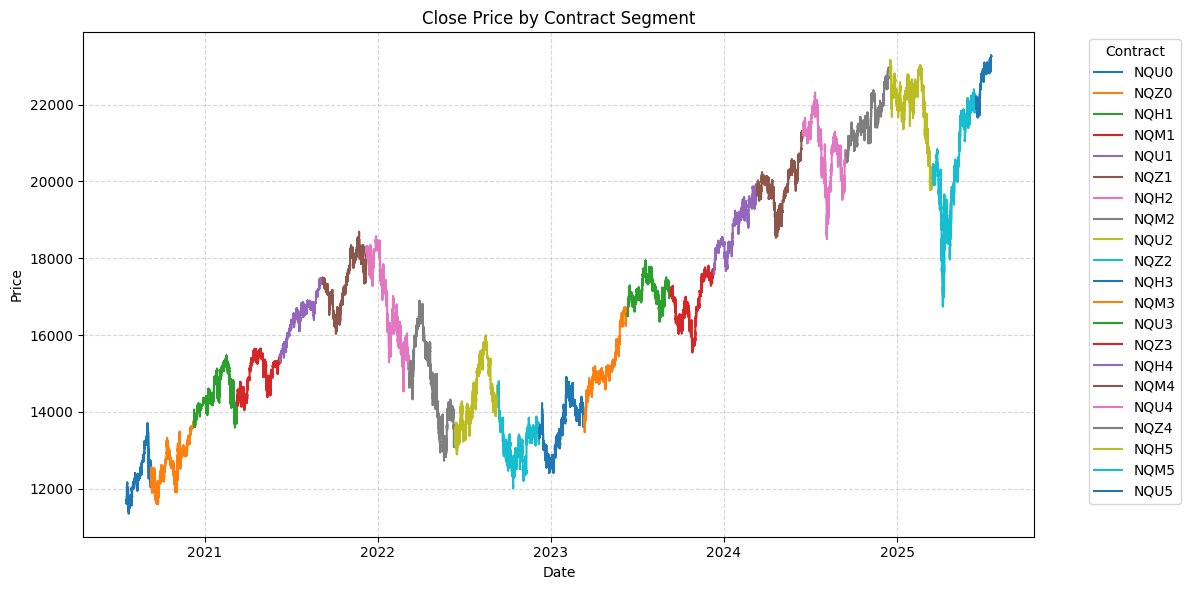

In [7]:
plot_segments(continuous_df_backadjusted, price_col='close', volume=False)

In [8]:
# import databento as db

# client = db.Historical("db-EvyqvhuAq7eJhX3nutvcqEpvh4Gh7")
# data = client.timeseries.get_range(
#     dataset="GLBX.MDP3",
#     symbols="ALL_SYMBOLS",
#     start="2022-06-02T14:20:00",
#     end="2022-06-02T14:30:00",
# )

# data.replay(print)

/opt/miniconda3/envs/ta-reversals-env/lib/python3.11/site-packages/mplfinance/_arg_validators.py:84: UserWarning: 


            POSSIBLE TO SEE DETAILS (Candles, Ohlc-Bars, Etc.)
   For more information see:
   - https://github.com/matplotlib/mplfinance/wiki/Plotting-Too-Much-Data
   
   TO SILENCE THIS WARNING, set `type='line'` in `mpf.plot()`
   OR set kwarg `warn_too_much_data=N` where N is an integer 
   LARGER than the number of data points you want to plot.

  warnings.warn('\n\n ================================================================= '+


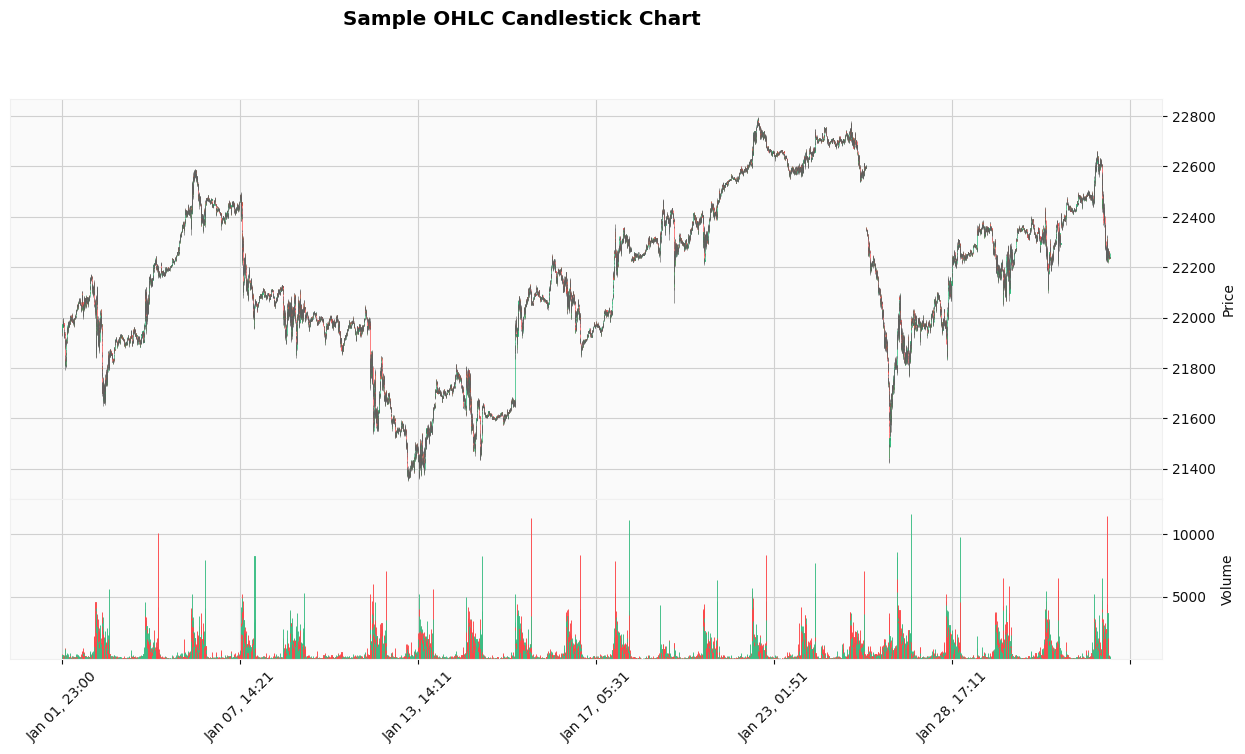

In [12]:
import pandas as pd
import matplotlib.pyplot as plt
import mplfinance as mpf
data_5m_recent = continuous_df_backadjusted[(continuous_df_backadjusted.index.year == 2025) & (continuous_df_backadjusted.index.month == 1)]
mpf.plot(
    data_5m_recent,
    type="candlestick",           # candlestick chart
    style="yahoo",           # one of many built-in styles
    volume=True,             # include volume subplot
    title="Sample OHLC Candlestick Chart",                # 3-period moving average
    figsize=(16, 8)
)

plt.show()


In [37]:
continuous_df_backadjusted

,Open,High,Low,Close,Volume,symbol
timestamp,,,,,,
2020-07-20 00:00:00+00:00,11712.986537,11716.011798,11711.611418,11712.986537,107.0,NQU0
2020-07-20 00:01:00+00:00,11713.261560,11713.261560,11708.861180,11710.786347,112.0,NQU0
2020-07-20 00:02:00+00:00,11710.236299,11713.811608,11709.961275,11713.811608,44.0,NQU0
2020-07-20 00:03:00+00:00,11712.986537,11713.261560,11710.236299,11710.511323,59.0,NQU0
2020-07-20 00:04:00+00:00,11710.511323,11710.786347,11709.411228,11710.511323,47.0,NQU0
...,...,...,...,...,...,...
2025-07-17 23:55:00+00:00,23279.500000,23279.750000,23277.500000,23278.000000,66.0,NQU5
2025-07-17 23:56:00+00:00,23278.250000,23279.250000,23277.000000,23277.750000,62.0,NQU5
2025-07-17 23:57:00+00:00,23278.000000,23281.250000,23277.500000,23281.250000,83.0,NQU5


In [57]:
import pandas as pd
import numpy as np
from backtesting import Strategy, Backtest

# --- 1. Define the Strategy ---
class MomentumTrendStrategy(Strategy):
    """
    Short-term momentum strategy using a custom Rate of Change (ROC)
    indicator and a Simple Moving Average (SMA) trend filter.
    """
    
    # Parameters
    roc_period = 5
    sma_period = 50
    roc_threshold = 0.001
    sl_pct = 0.005 
    tp_pct = 0.010 

    def init(self):
        """Initializes the indicators."""
        self.sma = self.I(
            lambda x: pd.Series(x).rolling(self.sma_period).mean(), 
            self.data.Close,
            name='SMA',
            plot=True,
            overlay=True
        )
        
        def roc_func(data, period):
            data = np.array(data)
            roc_values = np.insert((data[period:] - data[:-period]) / data[:-period], 0, [np.nan] * period)
            return roc_values

        self.roc = self.I(
            roc_func, 
            self.data.Close, 
            self.roc_period,
            name='ROC',
            plot=True,
            overlay=False
        )

    def next(self):
        """Defines the entry and exit logic."""
        if self.position:
            return

        price = self.data.Close[-1]
        sma_value = self.sma[-1]
        roc_value = self.roc[-1]
        
        # Long Entry
        if price > sma_value and roc_value > self.roc_threshold:
            sl = price * (1 - self.sl_pct)
            tp = price * (1 + self.tp_pct)
            self.buy(sl=sl, tp=tp)
            
        # Short Entry
        elif price < sma_value and roc_value < -self.roc_threshold:
            sl = price * (1 + self.sl_pct)
            tp = price * (1 - self.tp_pct)
            self.sell(sl=sl, tp=tp)

# --- 2. Load the User's Data ---
# Use the DataFrame as specified by the user
df = continuous_df_backadjusted[(continuous_df_backadjusted.index.year == 2025) & (continuous_df_backadjusted.index.month.isin([1]))].copy()

# --- 3. Run the Backtest ---
bt = Backtest(
    data=df,
    strategy=MomentumTrendStrategy,
    cash=100_000,
    commission=.002,
    exclusive_orders=True
)

output = bt.run()

# --- 4. Display Results ---
print(output)
bt.plot(filename='my_backtest_plot.html', open_browser=True)

/var/folders/mv/z1xz77z55w58nq2fljfj8dvh0000gn/T/ipykernel_59236/4232911781.py:77: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  output = bt.run()
/opt/miniconda3/envs/ta-reversals-env/lib/python3.11/site-packages/backtesting/_plotting.py:141: UserWarning: Data contains too many candlesticks to plot; downsampling to '5min'. See `Backtest.plot(resample=...)`
  warnings.warn(f"Data contains too many candlesticks to plot; downsampling to {freq!r}. "


Start                     2025-01-01 23:00...
End                       2025-01-31 21:59...
Duration                     29 days 22:59:00
Exposure Time [%]                    93.94475
Equity Final [$]                  80267.45942
Equity Peak [$]                  100261.07427
Commissions [$]                   19244.37351
Return [%]                          -19.73254
Buy & Hold Return [%]                 1.50223
Return (Ann.) [%]                   -91.00326
Volatility (Ann.) [%]                 1.92764
CAGR [%]                            -84.26024
Sharpe Ratio                        -47.20965
Sortino Ratio                        -3.55904
Calmar Ratio                         -4.42562
Alpha [%]                           -19.94777
Beta                                  0.14327
Max. Drawdown [%]                   -20.56284
Avg. Drawdown [%]                   -10.35775
Max. Drawdown Duration       29 days 21:42:00
Avg. Drawdown Duration       14 days 22:58:00
# Trades                          

/opt/miniconda3/envs/ta-reversals-env/lib/python3.11/site-packages/bokeh/util/serialization.py:242: UserWarning: no explicit representation of timezones available for np.datetime64
  return convert(array.astype("datetime64[us]"))


GridPlot(id='p9470', ...)